# XAI notebook — phân tích feature importance và giải thích mô hình

Notebook này demo quy trình chuẩn: cài đặt thư viện, tải dữ liệu, tiền xử lý, huấn luyện model baseline (RandomForest/LightGBM), và áp dụng các phương pháp giải thích như SHAP, LIME, Captum (Integrated Gradients). Các cell được ghi chú bằng tiếng Việt.

## Yêu cầu (requirements)

Một số package hữu ích cho notebook này:

- scikit-learn, pandas, numpy, matplotlib, seaborn
- lightgbm, xgboost (tùy chọn cho tree models)
- shap, lime
- torch, captum (nếu dùng NN và Integrated Gradients)
- joblib (lưu model)

Lệnh cài đặt (sử dụng pip):

```bash
pip install numpy pandas scikit-learn matplotlib seaborn joblib
pip install lightgbm xgboost
pip install shap lime
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118  # chọn đúng cuda hoặc cpu
pip install captum
```

Nếu bạn sử dụng conda, tạo environment mới và cài đặt tương tự.

In [9]:
# Cell: Imports and version checks
import sys
import platform
print('Python:', sys.version)
print('Platform:', platform.platform())

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

print('numpy', np.__version__)
print('pandas', pd.__version__)
import sklearn
print('scikit-learn', sklearn.__version__)

# optional packages — import safely and print version if available
from importlib import import_module

def _safe_import(pkg_name, attr_name='__version__'):
    """Import a package and try to return a human-friendly version string.
    - Prefer module.__version__ if present
    - Then try importlib.metadata.version(pkg_name)
    - Fallback to 'unknown' (but *not* repr(module)) so we don't print the module object)
    """
    try:
        mod = import_module(pkg_name)
    except Exception as e:
        return None, f'not available: {e}'

    # 1) common attribute on module
    ver = getattr(mod, attr_name, None)
    if ver:
        return mod, str(ver)

    # 2) importlib.metadata (prefer this when available)
    try:
        from importlib.metadata import version as _pkg_version, PackageNotFoundError
        try:
            ver = _pkg_version(pkg_name)
            return mod, str(ver)
        except PackageNotFoundError:
            pass
    except Exception:
        # older Python or importlib-metadata not available
        pass

    # 3) try to import a common submodule and read its __version__
    try:
        sub = import_module(pkg_name)
        ver = getattr(sub, attr_name, None)
        if ver:
            return mod, str(ver)
    except Exception:
        pass

    # 4) give a clean fallback (avoid returning repr(module) which confuses output)
    return mod, 'unknown'

# lightgbm
lgb, lgb_ver = _safe_import('lightgbm')
print('lightgbm', lgb_ver)

# shap
shap, shap_ver = _safe_import('shap')
print('shap', shap_ver)

# lime (some installs don't expose __version__ on top-level module)
lime, lime_ver = _safe_import('lime')
# try to get submodule version if top-level not helpful
if lime is not None and (lime_ver == 'unknown' or (isinstance(lime_ver, str) and lime_ver.startswith('not available'))):
    try:
        lm = import_module('lime.lime_tabular')
        lime_ver = getattr(lm, '__version__', lime_ver)
    except Exception:
        pass
print('lime', lime_ver)

# torch
torch, torch_ver = _safe_import('torch')
print('torch', torch_ver)

# captum
captum, captum_ver = _safe_import('captum')
print('captum', captum_ver)

print('\nReady to proceed.')

Python: 3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]
Platform: Windows-10-10.0.26100-SP0
numpy 1.26.4
pandas 2.2.3
scikit-learn 1.6.1
lightgbm 4.6.0
shap 0.48.0
lime 0.2.0.1
torch 2.6.0+cu118
captum 0.8.0

Ready to proceed.


In [7]:
# Cell: Load data and quick EDA
import os
p = 'train_test_network.csv'
if not os.path.exists(p):
    print(f"File {p} not found in workspace. Please place it here or update the path.")
else:
    df = pd.read_csv(p)
    print('Data shape:', df.shape)
    display(df.head())
    display(df.describe(include='all').T)
    print('\nMissing per column:')
    print(df.isna().sum())
    # Replace '-' with NaN and fill 'missing' as original script
    df = df.replace('-', np.nan).fillna('missing')
    if 'label' in df.columns:
        print('\nTarget distribution:')
        print(df['label'].value_counts(normalize=False))
        print(df['label'].value_counts(normalize=True))
    else:
        print('No column named label detected.')

    # Prepare X,y
    X = df.drop(['label','type'], axis=1) if 'label' in df.columns and 'type' in df.columns else df.drop(['label'], axis=1) if 'label' in df.columns else df.copy()
    y = df['label'] if 'label' in df.columns else None
    cat_cols = X.select_dtypes(include='object').columns.tolist()
    num_cols = X.select_dtypes(exclude='object').columns.tolist()
    print('\nNumeric cols count:', len(num_cols), 'Categorical cols count:', len(cat_cols))

Data shape: (211043, 44)


,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,http_response_body_len,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,-,290.371539,101568,2592,OTH,...,0,0,-,-,-,-,-,-,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000102,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000148,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000113,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,-,0.000130,0,0,REJ,...,0,0,-,-,-,-,-,-,1,backdoor


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
src_ip,211043,51,192.168.1.30,61633,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src_port,211043.0,NaN,NaN,NaN,38646.519543,19307.271048,1.0,34608.0,44754.0,51133.0,65528.0
dst_ip,211043,753,192.168.1.190,47795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dst_port,211043.0,NaN,NaN,NaN,3495.15377,10191.624778,0.0,65.0,80.0,1253.0,65467.0
proto,211043,3,tcp,168747,NaN,NaN,NaN,NaN,NaN,NaN,NaN
service,211043,9,-,132032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,211043.0,NaN,NaN,NaN,7.700887,564.141946,0.0,0.0,0.00017,0.054196,93516.92917
src_bytes,211043.0,NaN,NaN,NaN,258113.564274,17094901.249843,0.0,0.0,0.0,130.0,3890855126.0
dst_bytes,211043.0,NaN,NaN,NaN,258804.571575,18025629.248327,0.0,0.0,0.0,89.0,3913853482.0
conn_state,211043,13,S0,51937,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Missing per column:
src_ip                    0
src_port                  0
dst_ip                    0
dst_port                  0
proto                     0
service                   0
duration                  0
src_bytes                 0
dst_bytes                 0
conn_state                0
missed_bytes              0
src_pkts                  0
src_ip_bytes              0
dst_pkts                  0
dst_ip_bytes              0
dns_query                 0
dns_qclass                0
dns_qtype                 0
dns_rcode                 0
dns_AA                    0
dns_RD                    0
dns_RA                    0
dns_rejected              0
ssl_version               0
ssl_cipher                0
ssl_resumed               0
ssl_established           0
ssl_subject               0
ssl_issuer                0
http_trans_depth          0
http_method               0
http_uri                  0
http_version              0
http_request_body_len     0
http_response_body_len    0

Training RandomForest...

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     32209

    accuracy                           1.00     42209
   macro avg       1.00      1.00      1.00     42209
weighted avg       1.00      1.00      1.00     42209

Accuracy=1.0000 Precision=1.0000 Recall=1.0000 F1=1.0000 ROC_AUC=1.0


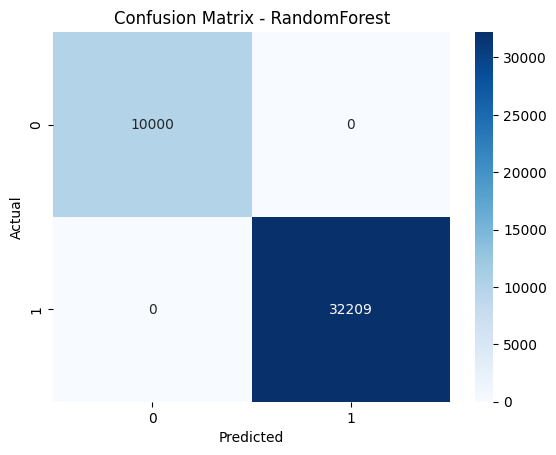

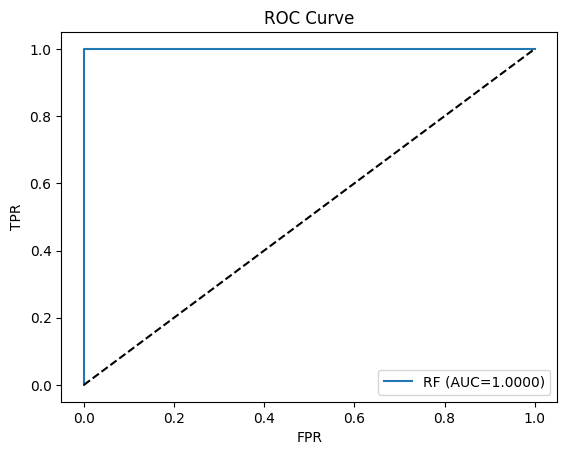

,feature,importance
16,src_ip,0.274818
18,proto,0.087253
7,src_ip_bytes,0.073040
6,src_pkts,0.072200
17,dst_ip,0.061032
25,dns_rejected,0.049004
1,dst_port,0.044881
0,src_port,0.036181
21,dns_query,0.033252
19,service,0.032040


Saved feature importances to feature_importances_best_model.csv

Training LightGBM...
[LightGBM] [Info] Number of positive: 128834, number of negative: 40000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2851
[LightGBM] [Info] Number of data points in the train set: 168834, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.763081 -> initscore=1.169645
[LightGBM] [Info] Start training from score 1.169645
LightGBM F1: 0.9999844761476008
Saved RandomForest pipeline to rf_pipeline.joblib


In [8]:
# Cell: Preprocessing, train/test split and baseline training
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

if y is None:
    print('No target variable available; skip training cells.')
else:
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)
    ], remainder='drop')

    # RandomForest pipeline
    rf_pipe = Pipeline([
        ('pre', preprocessor),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))
    ])

    print('Training RandomForest...')
    rf_pipe.fit(X_train_raw, y_train)
    y_pred = rf_pipe.predict(X_test_raw)
    y_proba = rf_pipe.predict_proba(X_test_raw)[:,1] if hasattr(rf_pipe.named_steps['clf'], 'predict_proba') else None

    print('\nClassification report:')
    print(classification_report(y_test, y_pred))

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(f'Accuracy={acc:.4f} Precision={prec:.4f} Recall={rec:.4f} F1={f1:.4f} ROC_AUC={auc}')

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix - RandomForest')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'RF (AUC={auc:.4f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC Curve')
        plt.legend()
        plt.show()

    # Feature importances from RandomForest
    try:
        # get feature names in order after ColumnTransformer
        feat_names = []
        feat_names.extend(num_cols)
        feat_names.extend(cat_cols)
        rf = rf_pipe.named_steps['clf']
        importances = rf.feature_importances_
        fi = pd.DataFrame({'feature': feat_names, 'importance': importances}).sort_values('importance', ascending=False)
        display(fi.head(30))
        fi.to_csv('feature_importances_best_model.csv', index=False)
        print('Saved feature importances to feature_importances_best_model.csv')
    except Exception as e:
        print('Could not extract feature_importances_ from RF:', e)

    # Try LightGBM as second example if available
    try:
        print('\nTraining LightGBM...')
        lgb_pipe = Pipeline([
            ('pre', preprocessor),
            ('clf', lgb.LGBMClassifier(random_state=42))
        ])
        lgb_pipe.fit(X_train_raw, y_train)
        y_pred_lgb = lgb_pipe.predict(X_test_raw)
        print('LightGBM F1:', f1_score(y_test, y_pred_lgb))
    except Exception as e:
        print('LightGBM training skipped or failed:', e)

    # Save RF pipeline
    try:
        import joblib
        joblib.dump(rf_pipe, 'rf_pipeline.joblib')
        print('Saved RandomForest pipeline to rf_pipeline.joblib')
    except Exception as e:
        print('Could not save pipeline:', e)

Computing SHAP values (sampled subset to save time) using shap.Explainer...


PermutationExplainer explainer: 501it [06:48,  1.19it/s]                         


SHAP array shape (samples x features): (500, 2)

Top SHAP features (sample):


,feature,shap_value,abs
0,f_0,0.0,0.0
1,f_1,0.0,0.0


Saved shap_feature_importances_sample.csv

Preparing LIME explainer...
LIME explanation for first test sample:


[('20.00 < src_ip <= 21.00', 0.1986268433505335),
 ('http_response_body_len <= -0.01', 0.13198603396739106),
 ('weird_name <= 8.00', -0.09385845488001168),
 ('proto <= 1.00', 0.0929093106734407),
 ('177.00 < dst_ip <= 182.00', -0.0268013238831404),
 ('missed_bytes <= -0.01', -0.02638991570979657),
 ('-0.34 < dst_port <= -0.34', 0.025472452939383806),
 ('http_status_code <= -0.04', 0.02488608091304958),
 ('dns_query <= 391.00', -0.01925934061920537),
 ('dst_pkts > -0.01', -0.01703301868772951)]

Saved lime_explanation_sample.csv


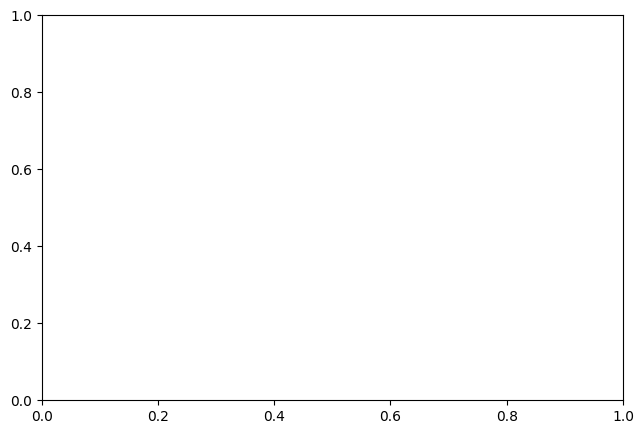

In [13]:
# Cell: SHAP explanations (robust) and LIME explanation for a sample
import numpy as np
import pandas as pd

# SHAP: use shap.Explainer when possible (more robust), else TreeExplainer fallback
try:
    import shap
    print('Computing SHAP values (sampled subset to save time) using shap.Explainer...')

    # Ensure required objects exist: preprocessor, rf_pipe or model
    try:
        pre = globals().get('preprocessor', None) or globals().get('pre', None) or (globals().get('rf_pipe') and globals()['rf_pipe'].named_steps['pre'])
    except Exception:
        pre = None
    try:
        clf = globals().get('rf') or (globals().get('rf_pipe') and globals()['rf_pipe'].named_steps.get('clf')) or globals().get('model')
    except Exception:
        clf = None

    # Reload data if necessary
    if 'X_train_raw' not in globals() or 'X_test_raw' not in globals():
        df = pd.read_csv('train_test_network.csv')
        df = df.replace('-', np.nan).fillna('missing')
        drop_cols = [c for c in ['src_ip','dst_ip'] if c in df.columns]
        df2 = df.drop(columns=drop_cols)
        X = df2.drop(columns=['label','type']) if 'type' in df2.columns else df2.drop(columns=['label'])
        y = df2['label']
        from sklearn.model_selection import train_test_split
        X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    if pre is None or clf is None:
        # try to load a saved pipeline
        try:
            import joblib
            pipe = joblib.load('rf_pipeline_no_id.joblib')
            pre = pipe.named_steps['pre']
            clf = pipe.named_steps['clf']
            print('Loaded pipeline from rf_pipeline_no_id.joblib')
        except Exception:
            try:
                pipe = joblib.load('rf_pipeline.joblib')
                pre = pipe.named_steps['pre']
                clf = pipe.named_steps['clf']
                print('Loaded pipeline from rf_pipeline.joblib')
            except Exception as e:
                raise RuntimeError('Could not find preprocessor or classifier in workspace or globals') from e

    # Build transformed feature names (numeric + transformed categorical)
    cat_cols = X_train_raw.select_dtypes(include='object').columns.tolist() if 'X_train_raw' in globals() else []
    num_cols = X_train_raw.select_dtypes(exclude='object').columns.tolist() if 'X_train_raw' in globals() else []
    try:
        cat_feature_names = list(pre.named_transformers_['cat'].get_feature_names_out(cat_cols)) if len(cat_cols)>0 and hasattr(pre, 'named_transformers_') else []
    except Exception:
        # fallback: use original cat column names
        cat_feature_names = cat_cols
    feat_names_trans = list(num_cols) + cat_feature_names

    # Transform training/test sets
    X_train_pre = pre.transform(X_train_raw)
    X_test_pre = pre.transform(X_test_raw)

    # sample subset to speed up
    rng = np.random.default_rng(42)
    sample_idx = rng.choice(X_test_pre.shape[0], size=min(500, X_test_pre.shape[0]), replace=False)
    X_sample = X_test_pre[sample_idx]

    # expected number of features after transform
    n_feat_expected = X_train_pre.shape[1]

    # Use shap.Explainer(prediction_function, background) which returns a unified API
    try:
        pred_fn = clf.predict_proba
    except Exception:
        pred_fn = clf.predict

    sv = None
    try:
        if hasattr(shap, 'Explainer'):
            explainer = shap.Explainer(pred_fn, X_train_pre, feature_names=feat_names_trans if len(feat_names_trans)==n_feat_expected else None)
            shap_res = explainer(X_sample)
            vals = getattr(shap_res, 'values', None)
            if vals is None:
                vals = np.asarray(shap_res)
            vals = np.asarray(vals)

            # If vals has shape (n_samples, n_classes) -> no feature axis; fallback to TreeExplainer
            if vals.ndim == 2 and vals.shape[1] != n_feat_expected:
                print('shap.Explainer returned a 2D array with second dim != n_features; falling back to TreeExplainer')
                raise ValueError('Explainer returned class-only shape')

            if vals.ndim == 3:
                # common case: (n_samples, n_classes, n_features)
                # pick last class (positive) if more than 1
                if vals.shape[1] > 1:
                    sv = vals[:, -1, :]
                else:
                    sv = vals[:, 0, :]
            elif vals.ndim == 2:
                sv = vals
            else:
                sv = vals.reshape(vals.shape[0], -1)

        else:
            raise AttributeError('shap.Explainer not available')
    except Exception:
        # fallback path using TreeExplainer which works reliably for tree-based classifiers
        try:
            print('Attempting fallback: shap.TreeExplainer on classifier (preprocessed inputs)...')
            expl = shap.TreeExplainer(clf)
            shap_values = expl.shap_values(X_sample)
            if isinstance(shap_values, list):
                # often list of arrays per class
                arr = np.asarray(shap_values[-1])
            else:
                arr = np.asarray(shap_values)
            if arr.ndim == 3:
                arr = arr.reshape(arr.shape[0], -1)
            sv = arr
        except Exception as e2:
            raise RuntimeError('Both shap.Explainer and TreeExplainer failed to produce per-feature SHAP values') from e2

    # Ensure sv is 2D
    sv = np.asarray(sv)
    if sv.ndim == 1:
        sv = sv.reshape(1, -1)

    # Now sv should be (n_samples, n_features_transformed)
    print('SHAP array shape (samples x features):', sv.shape)

    # choose a single sample to show local table (first in sample)
    single = sv[0]
    n_features_observed = single.shape[0]

    # pick feature names of matching length; if unavailable, synthesize names
    if len(feat_names_trans) == n_features_observed:
        feat_names_for_df = feat_names_trans
    else:
        # try to infer from preprocessor if possible
        try:
            if hasattr(pre, 'named_transformers_') and 'cat' in pre.named_transformers_:
                try:
                    cat_names = list(pre.named_transformers_['cat'].get_feature_names_out(cat_cols))
                except Exception:
                    cat_names = cat_cols
            else:
                cat_names = cat_cols
            candidate = list(num_cols) + cat_names
            if len(candidate) == n_features_observed:
                feat_names_for_df = candidate
            else:
                # last resort: synthesized names
                feat_names_for_df = [f'f_{i}' for i in range(n_features_observed)]
        except Exception:
            feat_names_for_df = [f'f_{i}' for i in range(n_features_observed)]

    # Build DataFrame safely
    shap_df = pd.DataFrame({'feature': feat_names_for_df, 'shap_value': single})
    shap_df['abs'] = shap_df['shap_value'].abs()
    shap_df = shap_df.sort_values('abs', ascending=False)
    print('\nTop SHAP features (sample):')
    display(shap_df.head(20))
    shap_df.to_csv('shap_feature_importances_sample.csv', index=False)
    print('Saved shap_feature_importances_sample.csv')

    # summary plot (uses original feature matrix if names align)
    try:
        shap.summary_plot(sv, X_sample, feature_names=feat_names_for_df)
    except Exception:
        try:
            shap.summary_plot(sv, X_sample)
        except Exception:
            pass

    # dependence plot for top feature if available
    try:
        top_idx = np.argmax(np.abs(single))
        shap.dependence_plot(top_idx, sv, X_sample, feature_names=feat_names_for_df)
    except Exception:
        pass

except Exception as e:
    print('SHAP not available or failed:', e)

# Cell: LIME explanation for a sample
try:
    from lime.lime_tabular import LimeTabularExplainer
    print('\nPreparing LIME explainer...')
    # Fit an explainer on training data (transformed)
    X_train_arr = pre.transform(X_train_raw).astype(float)
    X_test_arr = pre.transform(X_test_raw).astype(float)
    fnames = feat_names_trans if X_train_arr.shape[1] == len(feat_names_trans) else list(X_train_raw.columns)
    explainer_lime = LimeTabularExplainer(X_train_arr, feature_names=fnames, class_names=[str(c) for c in np.unique(y_train)], discretize_continuous=True)
    # explain first test sample
    exp = explainer_lime.explain_instance(X_test_arr[0], clf.predict_proba, num_features=10)
    print('LIME explanation for first test sample:')
    display(exp.as_list())
    # save lime explanation
    lime_list = exp.as_list()
    lime_df = pd.DataFrame(lime_list, columns=['feature','weight'])
    lime_df.to_csv('lime_explanation_sample.csv', index=False)
    print('Saved lime_explanation_sample.csv')
except Exception as e:
    print('LIME not available or failed:', e)


In [14]:
# Cell: Captum Integrated Gradients example (guarded)
try:
    import torch
    import torch.nn as nn
    from captum.attr import IntegratedGradients
    print('Preparing a small PyTorch model for IG demo...')
    # Prepare numeric-only subset for demo
    X_num = X[num_cols].astype(float).fillna(0).values
    y_arr = y.values
    # simple train/test split (reuse indices from earlier X_train_raw)
    Xn_train = preprocessor.named_transformers_['num'].fit_transform(X_train_raw[num_cols])
    Xn_test = preprocessor.named_transformers_['num'].transform(X_test_raw[num_cols])

    # small feedforward network
    class SmallNN(nn.Module):
        def __init__(self, n_in):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(n_in, 64),
                nn.ReLU(),
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            return self.net(x)

    model_nn = SmallNN(Xn_train.shape[1])
    # train briefly (toy) - use sklearn pipeline would be better but this is demo
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_nn.to(device)
    loss_fn = nn.BCELoss()
    opt = torch.optim.Adam(model_nn.parameters(), lr=1e-3)

    # create tensors (small epochs)
    Xt = torch.tensor(Xn_train, dtype=torch.float32).to(device)
    yt = torch.tensor((y_train.values).astype(float).reshape(-1,1), dtype=torch.float32).to(device)
    for epoch in range(3):
        model_nn.train()
        pred = model_nn(Xt)
        loss = loss_fn(pred, yt)
        opt.zero_grad(); loss.backward(); opt.step()
        print(f'Epoch {epoch} loss {loss.item():.4f}')

    # Integrated Gradients for first test numeric sample
    ig = IntegratedGradients(model_nn)
    model_nn.eval()
    sample = torch.tensor(Xn_test[0:1], dtype=torch.float32).to(device)
    attributions, delta = ig.attribute(sample, baselines=torch.zeros_like(sample), target=None, return_convergence_delta=True)
    at_np = attributions.detach().cpu().numpy().ravel()
    importances_ig = pd.DataFrame({'feature': num_cols, 'ig_attr': at_np}).sort_values('ig_attr', key=lambda x: np.abs(x), ascending=False)
    display(importances_ig.head(20))
except Exception as e:
    print('Captum/torch demo skipped or failed:', e)

Preparing a small PyTorch model for IG demo...
Epoch 0 loss 0.6843
Epoch 1 loss 0.6809
Epoch 2 loss 0.6775


,feature,ig_attr
0,src_port,-0.003458
1,dst_port,-0.001901
6,src_pkts,0.001315
10,dns_qclass,0.000865
11,dns_qtype,0.000736
15,http_status_code,-0.000593
4,dst_bytes,0.000512
9,dst_ip_bytes,0.000364
12,dns_rcode,0.000291
13,http_request_body_len,0.000260


## Kết luận & bước tiếp theo

Notebook này cung cấp một pipeline end-to-end để:

- Chuẩn bị dữ liệu và huấn luyện model baseline (RandomForest/LightGBM)
- Trích xuất feature importances (model builtin + permutation)
- Giải thích model bằng SHAP và LIME (nếu đã cài đặt)
- Ví dụ Integrated Gradients cho NN với Captum

Bước tiếp theo tôi có thể làm cho bạn:
- Chạy notebook và gửi output/tệp CSV kết quả (nếu bạn muốn tôi chạy trong workspace)
- Tinh chỉnh preprocessing (one-hot vs ordinal), cross-validation, hoặc lưu các explainer để phục vụ dashboard

Nếu muốn tôi chạy notebook tự động, cho phép tôi chạy các cell và tôi sẽ báo kết quả.

## 1) Global Explainability (Feature-level / toàn cục)

Cell này sẽ:
- Vẽ Partial Dependence Plots (PDP) cho một vài feature quan trọng.
- Huấn luyện một Global Surrogate (DecisionTree) trên dự đoán của model để có mô hình diễn giải đơn giản.

Lưu ý: PDP dùng scikit-learn, surrogate là cây đơn giản (depth nhỏ) để dễ trực quan hóa.

Loaded rf_pipeline_no_id.joblib
PDP requested features (original names): ['proto', 'dst_port', 'dst_ip_bytes']
Mapped features -> transformed indices: {'proto': [16], 'dst_port': [1], 'dst_ip_bytes': [9]}


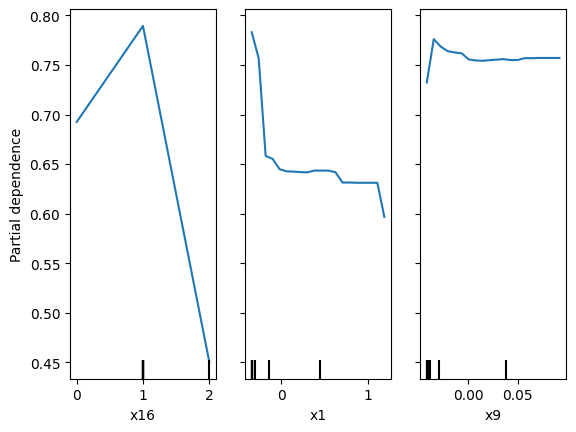


Training a shallow decision tree as a global surrogate...
Surrogate R^2 on model predictions: 0.8572475007218121


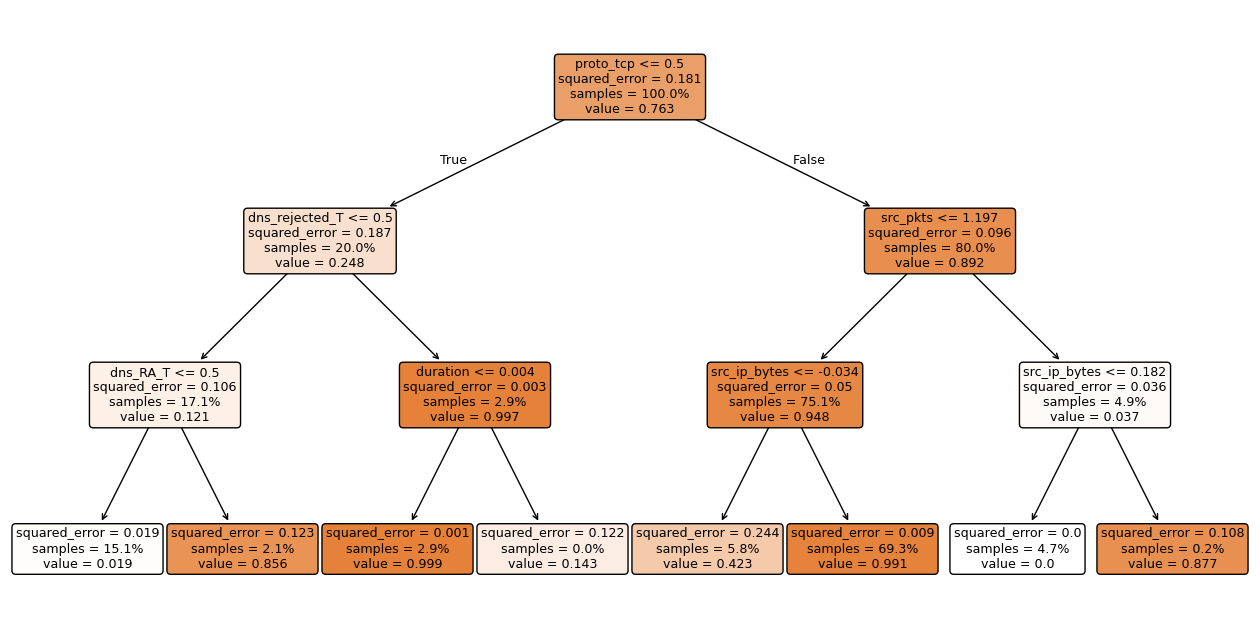

In [16]:
# PDP and Global surrogate
from sklearn.inspection import PartialDependenceDisplay
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Load model without ids if available
import joblib
try:
    model = joblib.load('rf_pipeline_no_id.joblib')
    print('Loaded rf_pipeline_no_id.joblib')
except Exception:
    model = None
    print('rf_pipeline_no_id.joblib not found, try rf_pipeline.joblib')
    try:
        model = joblib.load('rf_pipeline.joblib')
    except Exception as e:
        print('No saved pipeline found:', e)

# Prepare X (matching model input) from earlier cells or reload
import pandas as pd
p='train_test_network.csv'
df = pd.read_csv(p)
df = df.replace('-', np.nan).fillna('missing')
# drop ids if model_no_id
drop_cols = [c for c in ['src_ip','dst_ip'] if c in df.columns]
X = df.drop(columns=drop_cols)
X = X.drop(columns=['label','type']) if 'type' in X.columns else X.drop(columns=['label'])

# choose features for PDP: top permutation importances if available
try:
    perm = pd.read_csv('permutation_importance_no_id.csv')
    top_feats = perm['feature'].head(3).tolist()
except Exception:
    top_feats = X.columns.tolist()[:3]

print('PDP requested features (original names):', top_feats)

if model is not None:
    try:
        # get preprocessor and classifier from pipeline
        if hasattr(model, 'named_steps'):
            pre = model.named_steps['pre']
            clf = model.named_steps['clf']
        else:
            # model might already be a classifier only
            raise RuntimeError('Saved model is not a pipeline with preprocessor')

        # transform X to numeric array using preprocessor
        X_trans = pre.transform(X)

        # build transformed feature names
        cat_cols = X.select_dtypes(include='object').columns.tolist()
        num_cols = X.select_dtypes(exclude='object').columns.tolist()
        try:
            # many encoders expose get_feature_names_out
            cat_feature_names = list(pre.named_transformers_['cat'].get_feature_names_out(cat_cols)) if len(cat_cols)>0 and hasattr(pre.named_transformers_['cat'], 'get_feature_names_out') else cat_cols
        except Exception:
            cat_feature_names = cat_cols
        feat_names_trans = list(num_cols) + cat_feature_names

        # map original top_feats to indices in transformed feature names
        feat_to_indices = {}
        for f in top_feats:
            indices = [i for i, name in enumerate(feat_names_trans) if name == f or name.startswith(f + '_') or name.startswith(f + '__') or name.startswith(f + '-')]
            # if still empty and f is numeric feature, try exact match in num_cols
            if not indices and f in num_cols:
                i = num_cols.index(f)
                indices = [i]
            if not indices:
                print(f"Warning: could not map feature '{f}' to transformed columns; skipping it")
            else:
                feat_to_indices[f] = indices

        # flatten indices list preserving order
        indices_list = []
        for f in top_feats:
            if f in feat_to_indices:
                indices_list.extend(feat_to_indices[f])

        if not indices_list:
            raise RuntimeError('No valid transformed feature indices found for PDP')

        print('Mapped features -> transformed indices:', {k: feat_to_indices[k] for k in feat_to_indices})

        # Run PDP on classifier using transformed numeric array and integer indices
        # Note: pass clf (estimator expecting numeric features) and X_trans (numeric)
        PartialDependenceDisplay.from_estimator(clf, X_trans, features=indices_list, kind='average', grid_resolution=20)
        import matplotlib.pyplot as plt
        plt.show()

    except Exception as e:
        print('PDP failed:', e)

    # Global surrogate: train a shallow decision tree to predict model predictions
    print('\nTraining a shallow decision tree as a global surrogate...')
    # get predictions on X
    y_hat = model.predict(X)
    # train surrogate
    cat_cols = X.select_dtypes(include='object').columns.tolist()
    num_cols = X.select_dtypes(exclude='object').columns.tolist()
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import OneHotEncoder
    # Compatibility: newer sklearn uses `sparse_output` instead of deprecated `sparse`
    try:
        import inspect
        sig = inspect.signature(OneHotEncoder)
        if 'sparse' in sig.parameters:
            ohe_kwargs = dict(handle_unknown='ignore', sparse=False)
        else:
            ohe_kwargs = dict(handle_unknown='ignore', sparse_output=False)
    except Exception:
        ohe_kwargs = dict(handle_unknown='ignore', sparse_output=False)

    pre_sur = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(**ohe_kwargs), cat_cols)
    ], remainder='drop')
    X_trans_sur = pre_sur.fit_transform(X)
    sur = DecisionTreeRegressor(max_depth=3)
    sur.fit(X_trans_sur, y_hat)
    print('Surrogate R^2 on model predictions:', sur.score(X_trans_sur, y_hat))
    # show the tree
    import matplotlib.pyplot as plt
    plt.figure(figsize=(16,8))
    try:
        cat_feature_names = []
        if len(cat_cols) > 0:
            cat_feature_names = list(pre_sur.named_transformers_['cat'].get_feature_names_out(cat_cols))
        feat_names_all = list(num_cols) + cat_feature_names
    except Exception:
        feat_names_all = None
    plot_tree(sur, feature_names=feat_names_all, filled=True, proportion=True, rounded=True)
    plt.show()
else:
    print('Model not loaded; cannot compute PDP or surrogate')

In [16]:
# Run this from workspace root (PowerShell
import joblib, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('train_test_network.csv').replace('-', pd.NA).fillna('missing')
drop_cols = [c for c in ['src_ip','dst_ip'] if c in df.columns]
df2 = df.drop(columns=drop_cols)
X = df2.drop(columns=['label','type']) if 'type' in df2.columns else df2.drop(columns=['label'])
y = df2['label']

num_cols = X.select_dtypes(exclude='object').columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()

pre = ColumnTransformer([('num', StandardScaler(), num_cols),
                         ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols)], remainder='drop')
rf = Pipeline([('pre', pre), ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
rf.fit(X_train, y_train)
joblib.dump(rf, 'rf_pipeline_no_id.joblib')
print('Re-saved rf_pipeline_no_id.joblib')

Re-saved rf_pipeline_no_id.joblib


NameError: name 'PY' is not defined

## 2) Local Explainability (SHAP vs LIME comparison)

Cell này sẽ:
- Chọn cùng một sample test (ví dụ: sample index 0) và tính SHAP values (TreeExplainer) và LIME explanation cho sample đó.
- So sánh top-k features và hiển thị 2 bảng/plot cạnh nhau.

Lưu ý: cần package `shap` và `lime` đã cài.

In [17]:
# SHAP vs LIME comparison for a single sample (robust TreeExplainer version)
import numpy as np
from sklearn.model_selection import train_test_split
import joblib
import pandas as pd
try:
    import shap
    from lime.lime_tabular import LimeTabularExplainer

    # Load pipeline
    model = joblib.load('rf_pipeline_no_id.joblib')

    # prepare X_test
    df = pd.read_csv('train_test_network.csv')
    df = df.replace('-', np.nan).fillna('missing')
    drop_cols = [c for c in ['src_ip','dst_ip'] if c in df.columns]
    df2 = df.drop(columns=drop_cols)
    X = df2.drop(columns=['label','type']) if 'type' in df2.columns else df2.drop(columns=['label'])
    y = df2['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    # pick index 0 sample
    sample = X_test.iloc[0:1]

    # prepare preprocessor and classifier
    pre = model.named_steps['pre']
    clf = model.named_steps['clf']

    # build transformed feature names
    cat_cols = X.select_dtypes(include='object').columns.tolist()
    num_cols = X.select_dtypes(exclude='object').columns.tolist()
    try:
        cat_feature_names = list(pre.named_transformers_['cat'].get_feature_names_out(cat_cols)) if len(cat_cols)>0 else []
    except Exception:
        cat_feature_names = []
    feat_names_trans = list(num_cols) + cat_feature_names

    # helper to extract per-feature SHAP array robustly
    def extract_shap_array(shap_vals, n_features):
        import numpy as _np
        arr = shap_vals
        # if list, prefer class-1 contribution if present
        if isinstance(arr, list):
            # try class 1 first (common binary case)
            for candidate in (arr[1::-1] if len(arr)>1 else arr):
                a = _np.asarray(candidate)
                # common shapes: (n_samples, n_features) or (n_features,) or (1,n_features)
                if a.size == 0:
                    continue
                if a.ndim == 1 and a.shape[0] == n_features:
                    return a
                if a.ndim == 2 and a.shape[-1] == n_features:
                    return a.reshape(-1, n_features)[0]
                if a.ndim == 3:
                    # try to find axis equals n_features
                    if a.shape[-1] == n_features:
                        return a.reshape(-1, n_features)[0]
                    if a.shape[1] == n_features:
                        return a.reshape(-1, n_features)[0]
                    if a.shape[0] == n_features:
                        return a.reshape(-1, n_features)[0]
            # fallback: ravel
            return _np.ravel(_np.asarray(arr))
        else:
            a = _np.asarray(arr)
            if a.ndim == 1 and a.shape[0] == n_features:
                return a
            if a.ndim == 2 and a.shape[-1] == n_features:
                return a.reshape(-1, n_features)[0]
            if a.ndim == 3:
                if a.shape[-1] == n_features:
                    return a.reshape(-1, n_features)[0]
                if a.shape[1] == n_features:
                    return a.reshape(-1, n_features)[0]
                if a.shape[0] == n_features:
                    return a.reshape(-1, n_features)[0]
            return _np.ravel(a)

    # SHAP: TreeExplainer on the classifier, using preprocessed numeric background
    try:
        X_train_pre = pre.transform(X_train)
        samp_pre = pre.transform(sample)
        n_feat = X_train_pre.shape[1]
        explainer = shap.TreeExplainer(clf)
        shap_vals = explainer.shap_values(samp_pre)
        print('raw shap_values type:', type(shap_vals))
        # extract single per-feature vector
        shap_arr = extract_shap_array(shap_vals, n_feat)
        print('extracted shap vector length:', len(shap_arr), 'expected:', n_feat)
        if len(shap_arr) != len(feat_names_trans):
            print('Warning: shap length != transformed feature names; falling back to original X column names')
            feat_names_for_df = list(X.columns)
        else:
            feat_names_for_df = feat_names_trans
        shap_df = pd.DataFrame({'feature': feat_names_for_df, 'shap_value': shap_arr})
        shap_df['abs'] = shap_df['shap_value'].abs()
        shap_df = shap_df.sort_values('abs', ascending=False)
        print('\nTop SHAP features (transformed features):')
        display(shap_df.head(15))
        shap_df.to_csv('shap_feature_importances_sample.csv', index=False)
        print('Saved shap_feature_importances_sample.csv')
    except Exception as e:
        print('SHAP TreeExplainer failed:', e)
        raise

    # LIME on preprocessed arrays
    try:
        X_train_arr = pre.transform(X_train).astype(float)
        X_test_arr = pre.transform(X_test).astype(float)
        fnames = feat_names_trans if X_train_arr.shape[1] == len(feat_names_trans) else list(X.columns)
        explainer_lime = LimeTabularExplainer(X_train_arr, feature_names=fnames, class_names=[str(c) for c in np.unique(y)], discretize_continuous=True)
        exp = explainer_lime.explain_instance(X_test_arr[0], clf.predict_proba, num_features=10)
        lime_list = exp.as_list()
        lime_df = pd.DataFrame(lime_list, columns=['feature','weight'])
        print('\nLIME explanation (top):')
        display(lime_df)
        lime_df.to_csv('lime_explanation_sample.csv', index=False)
        print('Saved lime_explanation_sample.csv')
    except Exception as e:
        print('LIME failed:', e)
        raise

except Exception as e:
    import traceback
    traceback.print_exc()
    print('SHAP/LIME comparison failed or packages missing:', e)
    print('Install shap and lime (and retry) or check pipeline compatibility.')

raw shap_values type: <class 'numpy.ndarray'>
extracted shap vector length: 40 expected: 40

Top SHAP features (transformed features):


,feature,shap_value,abs
3,src_bytes,0.056440,0.056440
2,duration,-0.056440,0.056440
32,http_uri,-0.031329,0.031329
33,http_version,0.031329,0.031329
12,dns_rcode,-0.022625,0.022625
13,http_request_body_len,0.022625,0.022625
16,proto,-0.021109,0.021109
17,service,0.021109,0.021109
34,http_user_agent,-0.020268,0.020268
35,http_orig_mime_types,0.020268,0.020268


Saved shap_feature_importances_sample.csv

LIME explanation (top):


,feature,weight
0,proto <= 1.00,0.120332
1,-0.34 < dst_port <= -0.34,0.057222
2,http_status_code <= -0.04,0.043322
3,service <= 4.00,-0.033149
4,dst_pkts > -0.01,-0.029477
5,-0.01 < duration <= -0.01,0.026246
6,http_request_body_len <= -0.01,-0.024803
7,missed_bytes <= -0.01,0.020032
8,src_ip_bytes > -0.02,0.017596
9,dns_rcode <= -0.21,-0.014684


Saved lime_explanation_sample.csv


### Optional: Counterfactual explanations (DiCE / Alibi)

- DiCE and Alibi can generate counterfactuals; they require additional installation and model wrappers.
- If bạn muốn, tôi có thể thêm một cell demo sử dụng DiCE (pip install dice-ml) hoặc Alibi to generate counterfactuals for a sample and show required changes to flip model prediction.

Nếu muốn chạy cell demo Counterfactuals bây giờ, trả lời `Có` và tôi sẽ cài DiCE/Alibi (pip) và chạy thử.